# Space Enterprise at Berkeley (Liquid) 2023


Here we go with another flight simulation example using RocketPy.
This time, we use data from the [Space Enterprise at Berkeley](https://www.berkeleyse.org/) team to perform
a trajectory simulation using the LiquidMotor.
Let's check it out!


In [1]:
# These lines are here for debugging purposes only
%load_ext autoreload
%autoreload 2

In [2]:
from rocketpy import (
    CylindricalTank,
    Environment,
    Flight,
    Fluid,
    Function,
    LiquidMotor,
    MassBasedTank,
    Rocket,
    UllageBasedTank,
)

## Input Curves


First, we need to load the curves generated by the team during the motor testings.

The information that we are using are basically the volume of LOX and Propane in the tanks


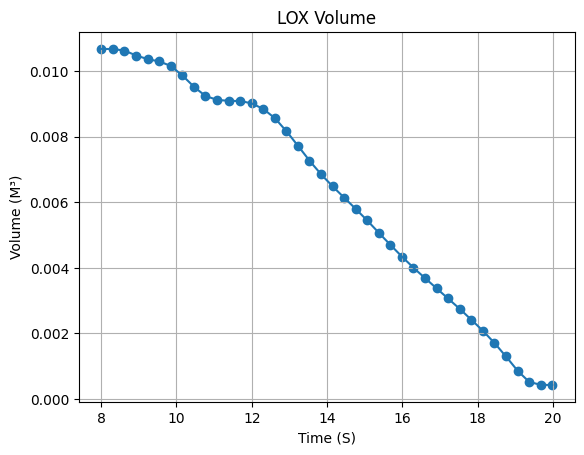

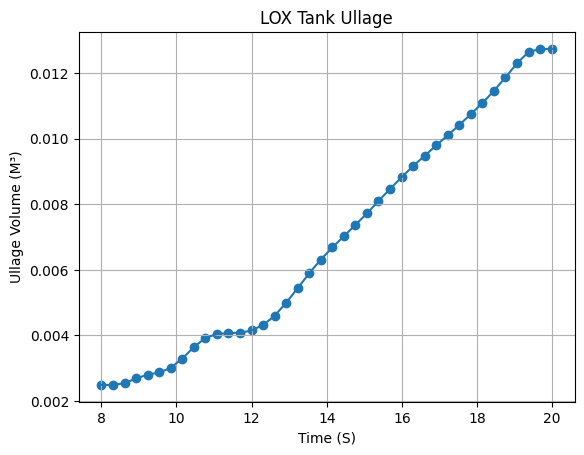

In [3]:
# Define and set up LOX volume
lox_volume_liters = Function(
    "../../data/rockets/berkeley/test124_Lox_Volume.csv",
    extrapolation="zero",
    inputs="Time (s)",
    outputs="Volume (L)",
)
lox_volume = lox_volume_liters * 0.001  # Convert to m^3
lox_volume.set_discrete(8.003, 19.984, 40, interpolation="linear")
lox_volume.set_outputs("Volume (m³)")
lox_volume.set_title("LOX Volume")

# Plot LOX volume
lox_volume.plot(force_data=True)

# Define and set up LOX tank ullage
lox_tank_ullage = 0.013167926436231077 - lox_volume
lox_tank_ullage.set_title("LOX Tank Ullage")
lox_tank_ullage.set_outputs("Ullage volume (m³)")

# Plot LOX tank ullage
lox_tank_ullage.plot(8, 20, force_data=True)

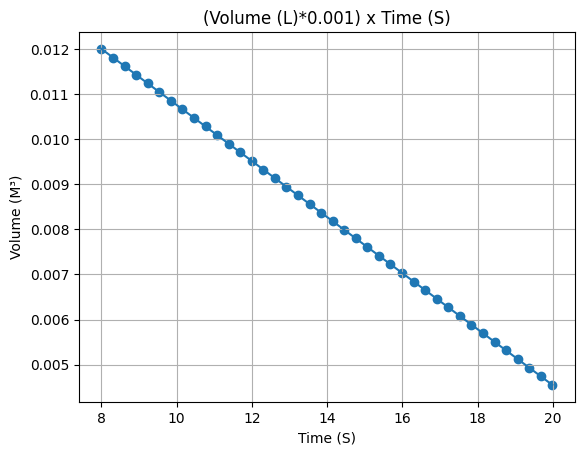

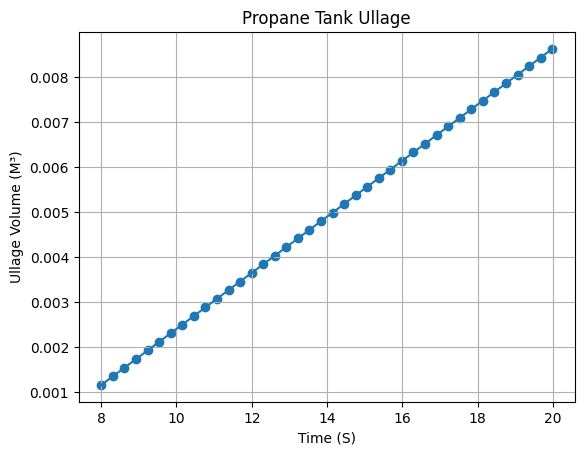

In [4]:
# Define and set up Propane volume
propane_volume_liters = Function(
    "../../data/rockets/berkeley/test124_Propane_Volume.csv",
    inputs="Time (s)",
    outputs="Volume (L)",
)
propane_volume = propane_volume_liters * 0.001  # Convert to m^3
propane_volume.set_discrete(8.003, 19.984, 40, interpolation="linear")
propane_volume.set_outputs("Volume (m³)")

# Plot Propane volume
propane_volume.plot(force_data=True)

# Define and set up Propane tank ullage
propane_tank_ullage = 0.013167926436231077 - propane_volume
propane_tank_ullage.set_title("Propane Tank Ullage")
propane_tank_ullage.set_outputs("Ullage volume (m³)")

# Plot Propane tank ullage
propane_tank_ullage.plot(force_data=True)

## Fluids


Now it's time to define the fluids that we are going to use in the simulation.


In [5]:
# Define fluids
lox = Fluid(name="LOX", density=1024)
propane = Fluid(name="Propane", density=566)

# Define pressurizing gases with their respective pressures
lox_tank_pressurizing_gas = Fluid(name="N2", density=31.3 / 28)  # 450 PSI
propane_tank_pressurizing_gas = Fluid(
    name="N2", density=313 * 300 / 4500 / 28
)  # 300 PSI
pressurizing_gas = Fluid(name="N2", density=300)  # 4500 PSI

## Tanks


After the fluids, it is time to define all the 3 tanks that we have in the motor.


### LOX Tank


We first start defining the tank geometry, which is a cylinder with a spherical head.


In [6]:
lox_tank_geometry = CylindricalTank(0.0744, 0.8068, spherical_caps=True)

Next, we use the tank geometry to define the tank itself.


In [7]:
lox_tank = UllageBasedTank(
    name="LOX Tank",
    flux_time=(8, 20),
    geometry=lox_tank_geometry,
    gas=lox_tank_pressurizing_gas,
    liquid=lox,
    ullage=lox_tank_ullage,
)

After defining, we stop for a minute to appreciate the evolution of mass
and mass flow rate that were calculated by RocketPy.

Isn't it beautiful?


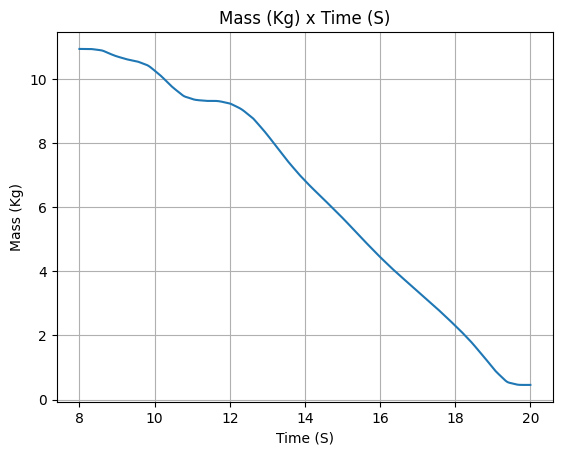

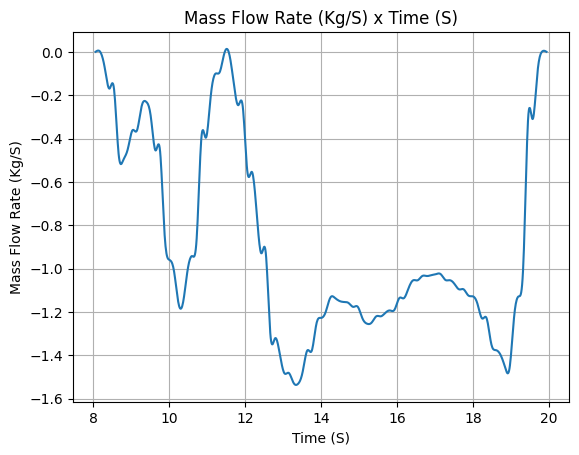

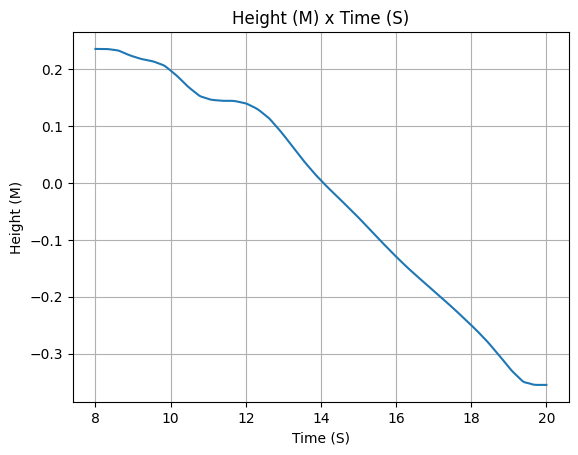

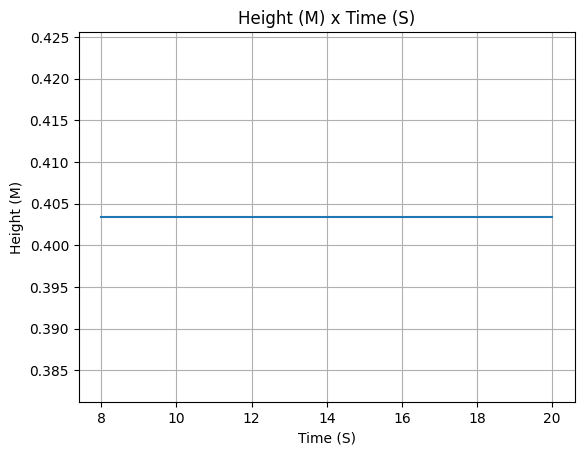

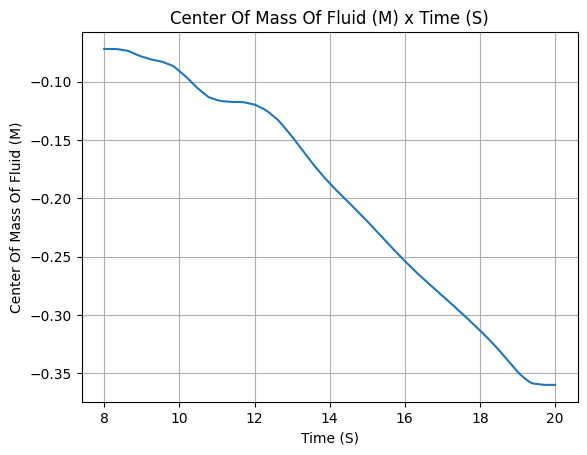

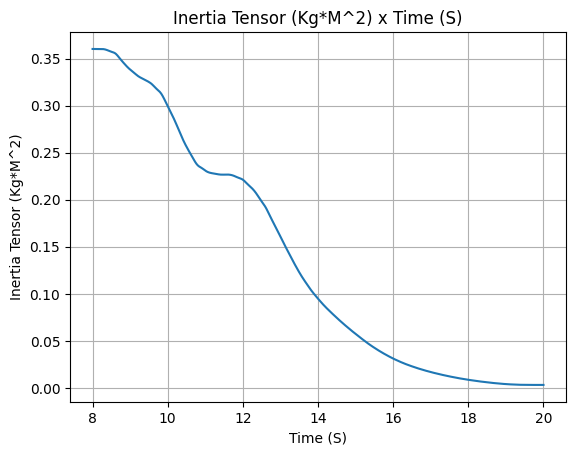

In [8]:
lox_tank.fluid_mass()
lox_tank.net_mass_flow_rate()
lox_tank.liquid_height()
lox_tank.gas_height()
lox_tank.center_of_mass()
lox_tank.inertia()

### Propane Tank


Our setup work is not done yet. We still need to define the propane tank,
Which is a cylinder with a spherical head.

The propane has the role of pressurizing the LOX tank.


In [9]:
propane_tank_geometry = CylindricalTank(0.0744, 0.8068, spherical_caps=True)

In [10]:
propane_tank = UllageBasedTank(
    name="Propane Tank",
    flux_time=(8, 20),
    geometry=propane_tank_geometry,
    gas=propane_tank_pressurizing_gas,
    liquid=propane,
    ullage=propane_tank_ullage,
)

Again, let's visualize the partial results.


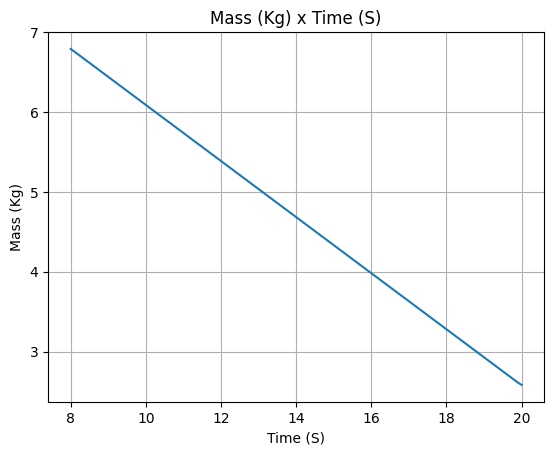

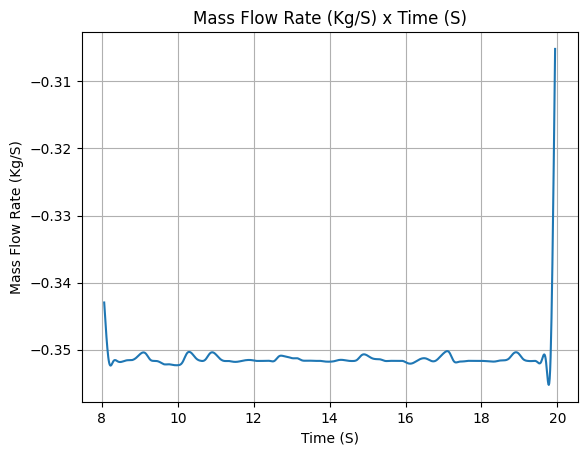

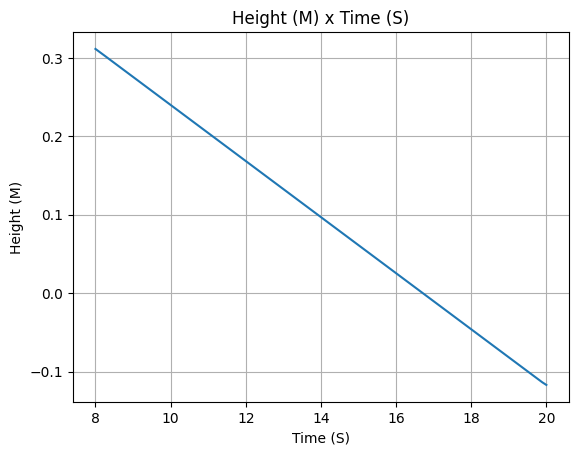

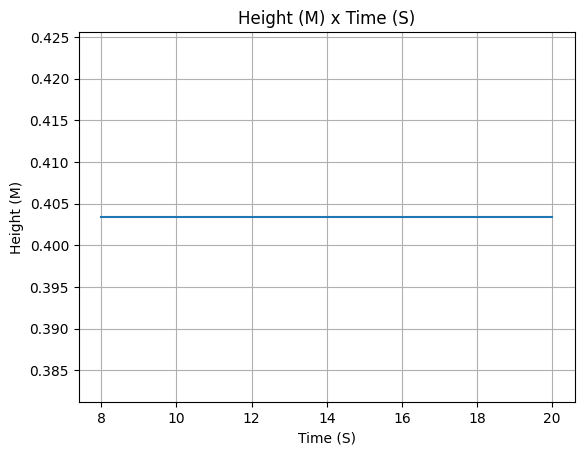

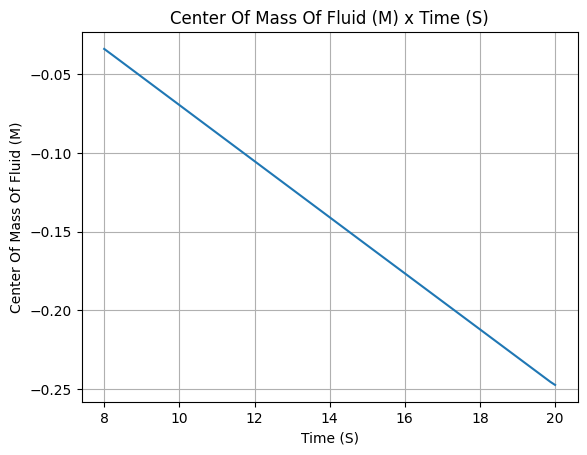

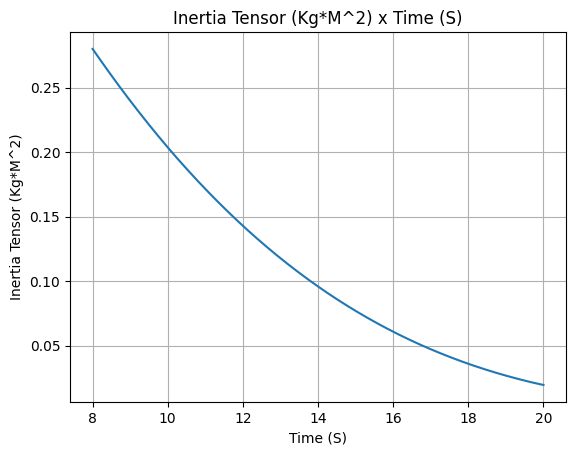

In [11]:
propane_tank.fluid_mass()
propane_tank.net_mass_flow_rate()
propane_tank.liquid_height()
propane_tank.gas_height()
propane_tank.center_of_mass()
propane_tank.inertia()

### Pressure Tank


The third tank is the pressure tank, which is a cylinder with a spherical head.


In [12]:
pressure_tank_geometry = CylindricalTank(0.135 / 2, 0.981, spherical_caps=True)

In [13]:
pressure_tank = MassBasedTank(
    name="Pressure Tank",
    geometry=pressure_tank_geometry,
    liquid_mass=0,
    flux_time=(8, 20),
    gas_mass="../../data/rockets/berkeley/pressurantMassFiltered.csv",
    gas=pressurizing_gas,
    liquid=pressurizing_gas,
)

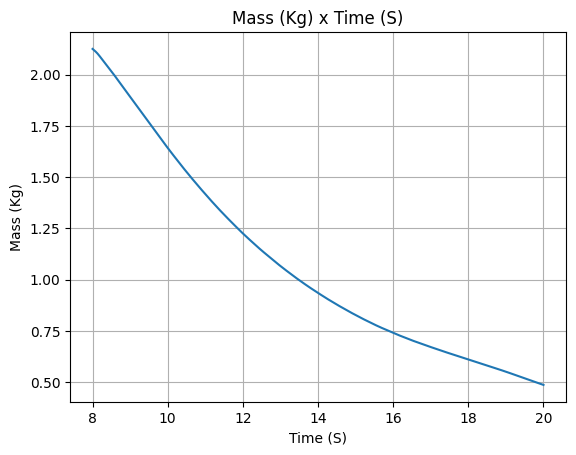

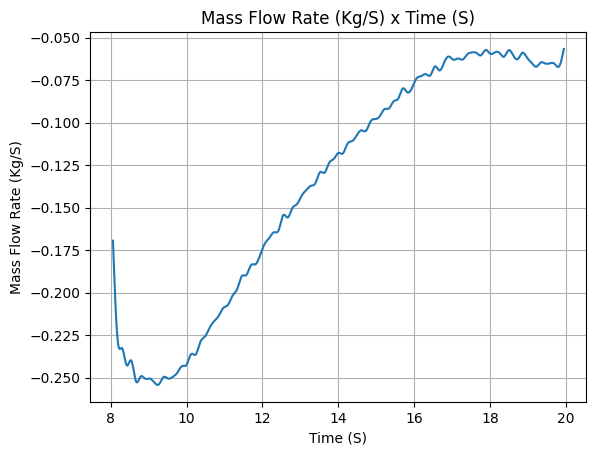

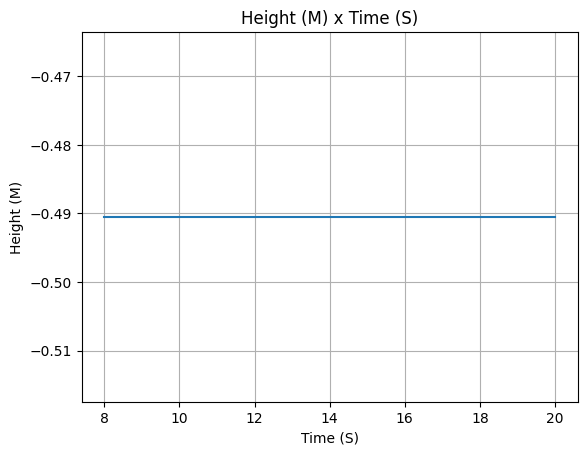

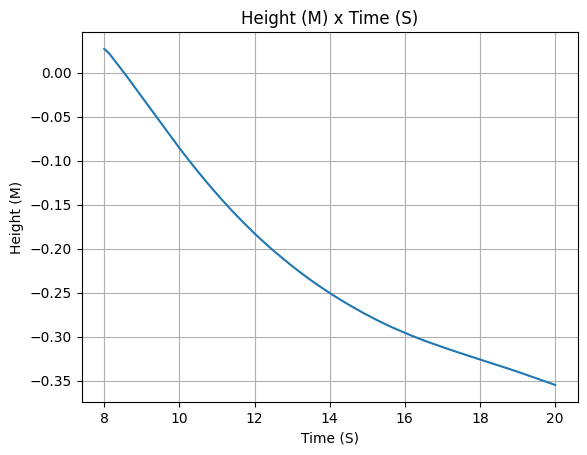

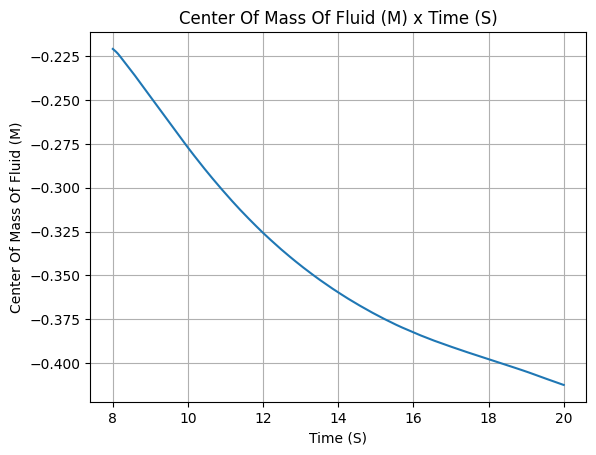

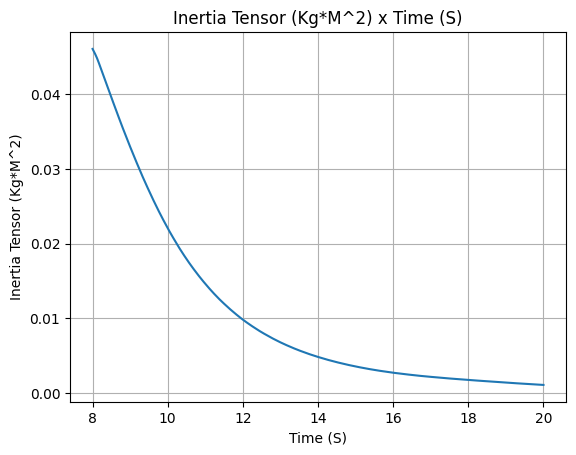

In [14]:
pressure_tank.fluid_mass()
pressure_tank.net_mass_flow_rate()
pressure_tank.liquid_height()
pressure_tank.gas_height()
pressure_tank.center_of_mass()
pressure_tank.inertia()

## Liquid Motor


After defining the three tanks, we can finally define the liquid motor object,
just check how simple it is!


In [15]:
liquid_motor = LiquidMotor(
    thrust_source="../../data/rockets/berkeley/test124_Thrust_Curve.csv",
    center_of_dry_mass_position=0,
    dry_inertia=(0, 0, 0),
    dry_mass=0,
    burn_time=(8, 20),
    nozzle_radius=0.069 / 2,
    nozzle_position=-1.364,
    coordinate_system_orientation="nozzle_to_combustion_chamber",
)

liquid_motor.add_tank(propane_tank, position=-0.6446)
liquid_motor.add_tank(lox_tank, position=1.1144)
liquid_motor.add_tank(pressure_tank, position=2.4975)

After defining it, we can check all the important information about the motor,
such as the thrust curve, the mass flow rate curve, the specific impulse curve,
and the burn time.


Nozzle Details
Nozzle Radius: 0.0345 m

Motor Details
Total Burning Time: 12 s
Total Propellant Mass: 19.852 kg
Average Propellant Exhaust Velocity: 1697.621 m/s
Average Thrust: 2064.885 N
Maximum Thrust: 2428.4243134124745 N at 17.666 s after ignition.
Total Impulse: 24778.624 Ns



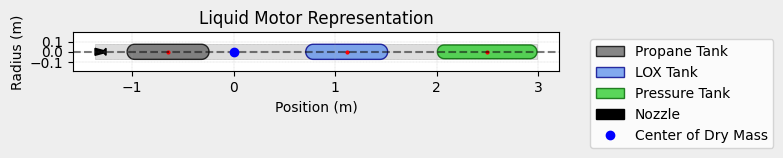

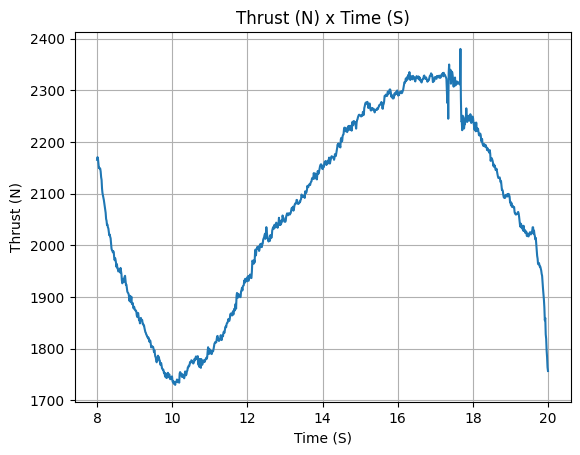

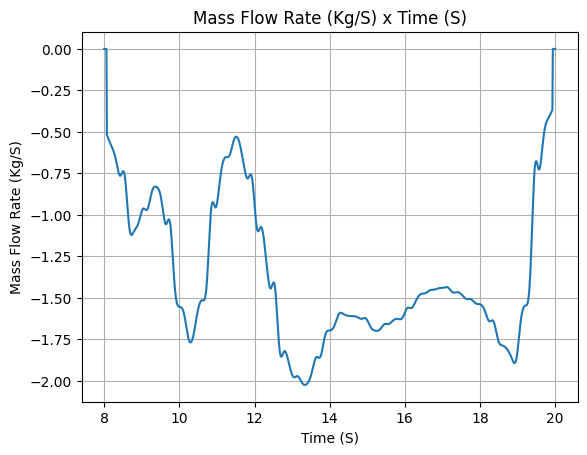

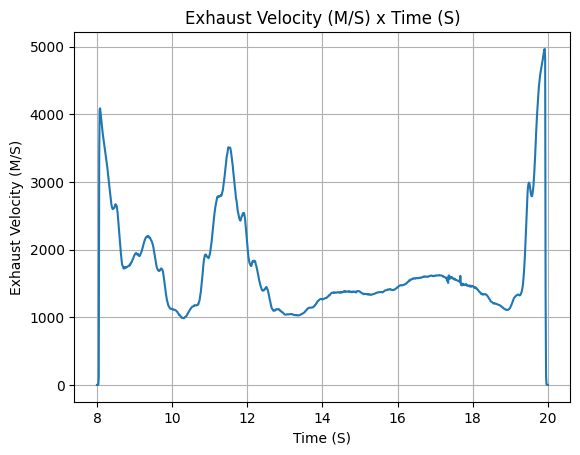

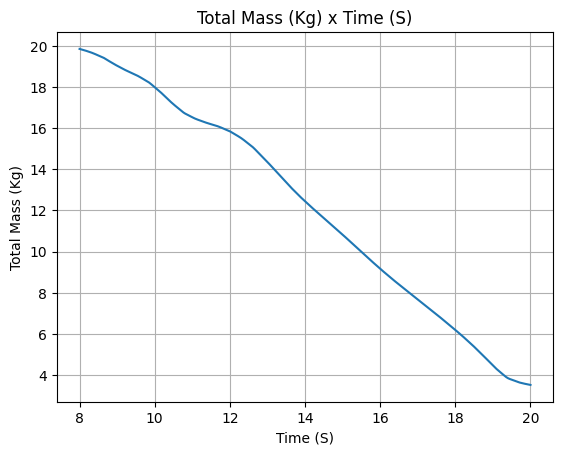

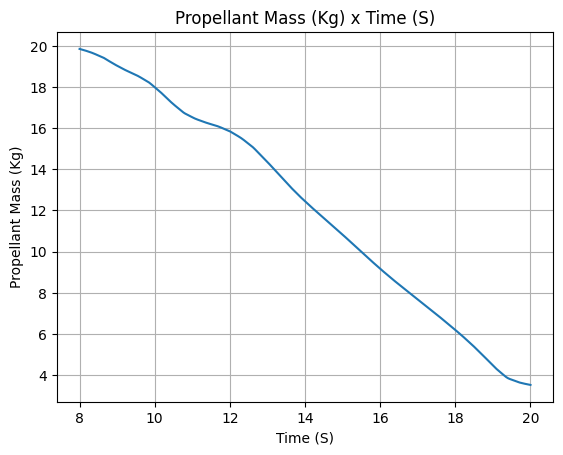

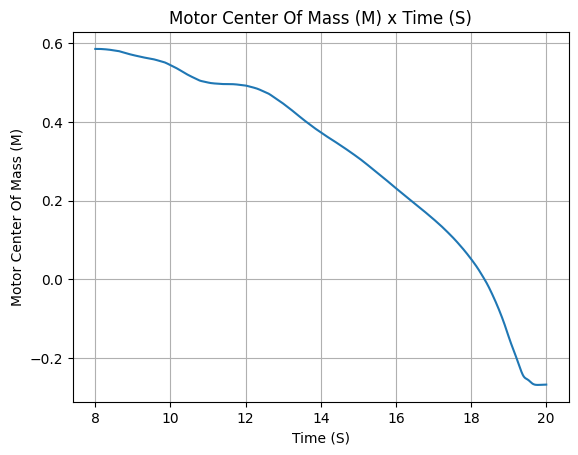

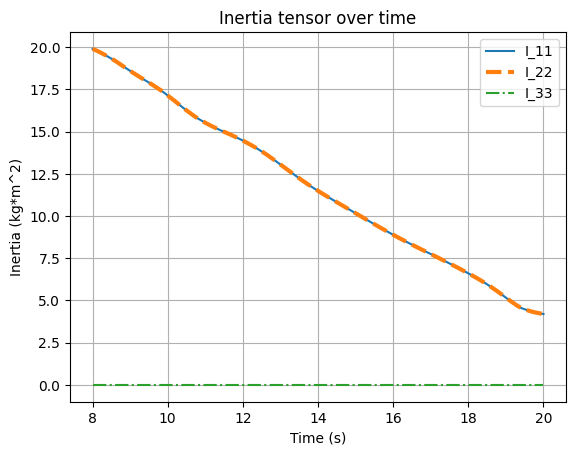

In [16]:
liquid_motor.all_info()

## Rocket Definition


The motor is ready to go, but we still need to define the rocket itself.
Let's see how it is done:


In [17]:
berkeley_rocket = Rocket(
    radius=0.098,
    mass=63.4,
    inertia=(25, 25, 1),
    power_off_drag="../../data/rockets/berkeley/drag.csv",
    power_on_drag="../../data/rockets/berkeley/drag.csv",
    center_of_mass_without_motor=3.23,
    coordinate_system_orientation="nose_to_tail",
)
berkeley_rocket.add_motor(liquid_motor, position=4.2)
nose = berkeley_rocket.add_nose(length=0.7, kind="vonKarman", position=0)
tail = berkeley_rocket.add_tail(
    top_radius=0.098, bottom_radius=0.058, length=0.198, position=5.69 - 0.198
)

fins = berkeley_rocket.add_trapezoidal_fins(
    n=4,
    root_chord=0.355,
    tip_chord=0.0803,
    span=0.156,
    position=5.25,
    cant_angle=0,
)


Inertia Details

Rocket Mass: 63.400 kg (without motor)
Rocket Dry Mass: 63.400 kg (with unloaded motor)
Rocket Loaded Mass: 83.252 kg
Rocket Inertia (with unloaded motor) 11: 25.000 kg*m2
Rocket Inertia (with unloaded motor) 22: 25.000 kg*m2
Rocket Inertia (with unloaded motor) 33: 1.000 kg*m2
Rocket Inertia (with unloaded motor) 12: 0.000 kg*m2
Rocket Inertia (with unloaded motor) 13: 0.000 kg*m2
Rocket Inertia (with unloaded motor) 23: 0.000 kg*m2

Geometrical Parameters

Rocket Maximum Radius: 0.098 m
Rocket Frontal Area: 0.030172 m2

Rocket Distances
Rocket Center of Dry Mass - Center of Mass without Motor: 0.000 m
Rocket Center of Dry Mass - Nozzle Exit: 2.334 m
Rocket Center of Dry Mass - Center of Propellant Mass: 0.384 m
Rocket Center of Mass - Rocket Loaded Center of Mass: 0.092 m


Aerodynamics Lift Coefficient Derivatives

Nose Cone Lift Coefficient Derivative: 2.000/rad
Tail Lift Coefficient Derivative: -1.299/rad
Fins Lift Coefficient Derivative: 5.895/rad

Center of Pre

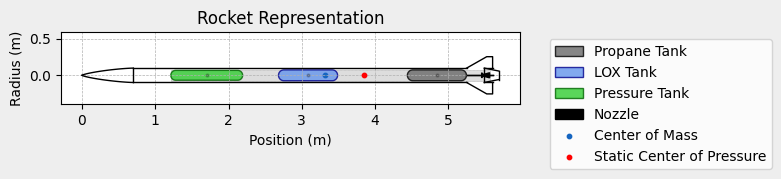


Mass Plots
----------------------------------------


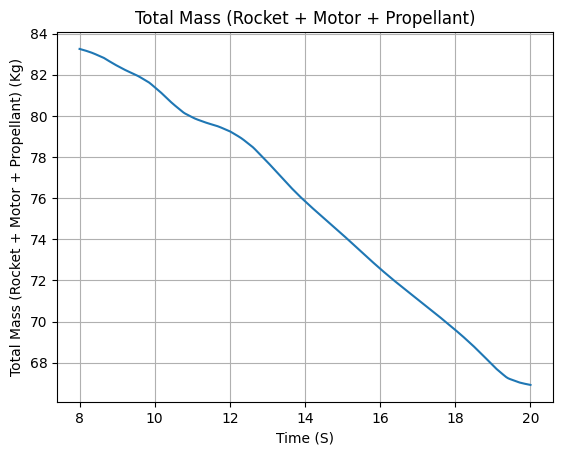

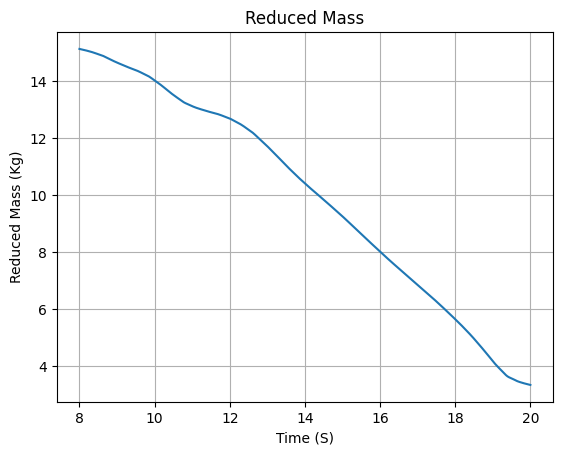


Aerodynamics Plots
----------------------------------------
Drag Plots
--------------------


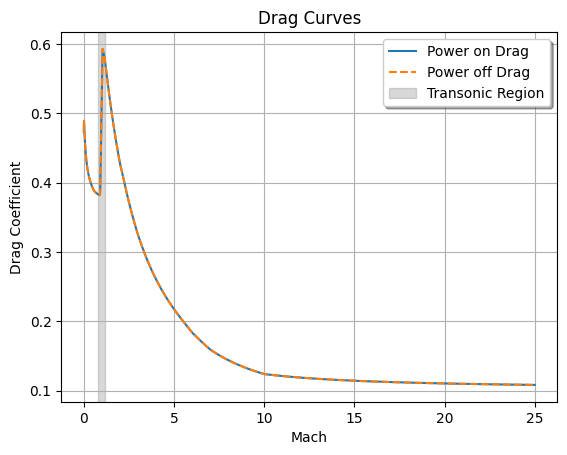


Stability Plots
--------------------


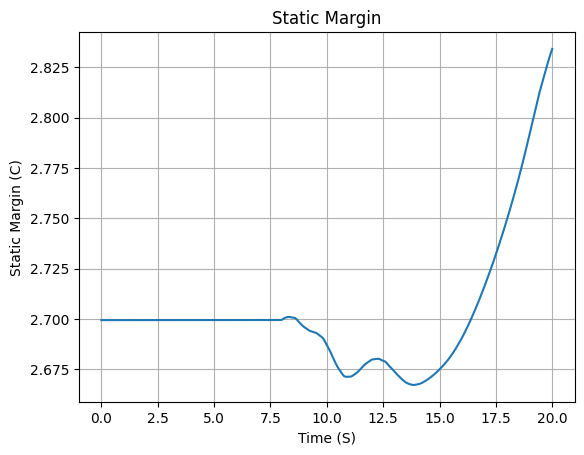

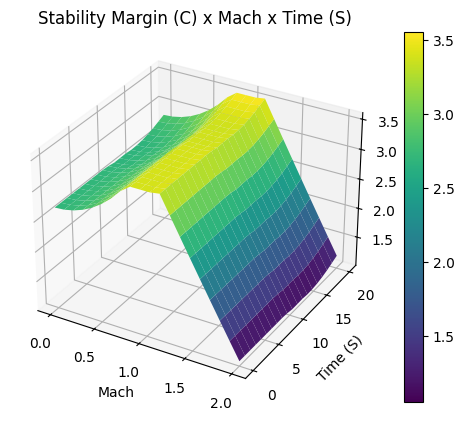


Thrust-to-Weight Plot
----------------------------------------


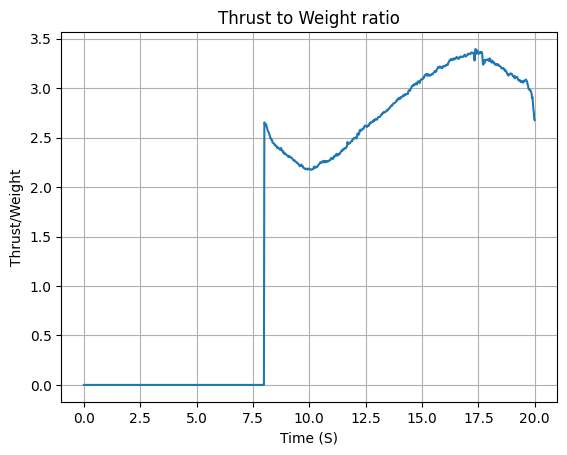

In [18]:
berkeley_rocket.all_info()

## Environment


I swear this is the last step before actually flying the rocket.
We need to define the environment in which the rocket will fly.


In [19]:
env = Environment(latitude=35.347122986338356, longitude=-117.80893423073582)

env.set_date((2022, 12, 3, 14 + 7, 0, 0))  # UTC

env.set_atmospheric_model(
    type="custom_atmosphere",
    pressure=None,
    temperature=None,
    wind_u=[(0, 1), (500, 0), (1000, 5), (2500, 5.0), (5000, 10)],
    wind_v=[(0, 0), (500, 3), (1600, 2), (2500, -3), (5000, 10)],
)


Gravity Details

Acceleration of gravity at surface level:    9.7976 m/s²
Acceleration of gravity at  80.000 km (ASL): 9.5554 m/s²


Launch Site Details

Launch Date: 2022-12-03 21:00:00 UTC
Launch Site Latitude: 35.34712°
Launch Site Longitude: -117.80893°
Reference Datum: SIRGAS2000
Launch Site UTM coordinates: 426495.69 W    3911838.99 N
Launch Site UTM zone: 11S
Launch Site Surface Elevation: 0.0 m


Atmospheric Model Details

Atmospheric Model Type: custom_atmosphere
custom_atmosphere Maximum Height: 80.000 km

Surface Atmospheric Conditions

Surface Wind Speed: 1.00 m/s
Surface Wind Direction: 270.00°
Surface Wind Heading: 90.00°
Surface Pressure: 1013.25 hPa
Surface Temperature: 288.15 K
Surface Air Density: 1.225 kg/m³
Surface Speed of Sound: 340.29 m/s


Earth Model Details

Earth Radius at Launch site: 6371.02 km
Semi-major Axis: 6378.14 km
Semi-minor Axis: 6356.75 km
Flattening: 0.0034


Atmospheric Model Plots



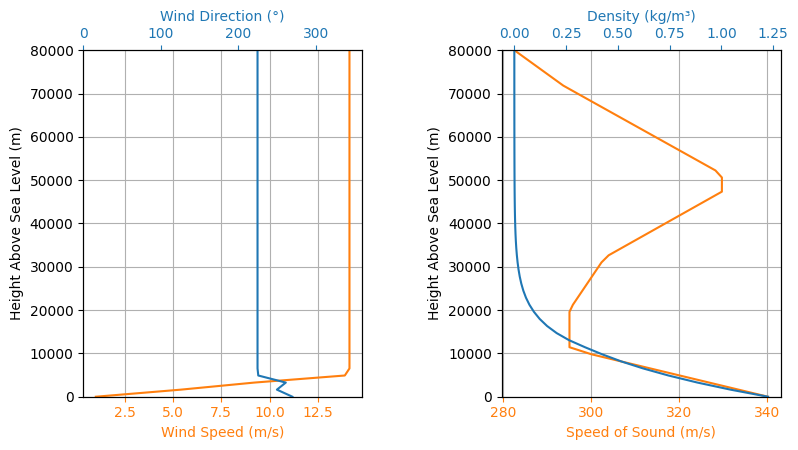

In [20]:
env.info()

## Flight Simulation


Finally, here we go with our flight simulation.
We are going to run the simulation only until the apogee, since we are not
interested in the landing phase.

The `max_time_step` parameter was set to a low value to ensure there won't be any
numerical instability during the launch rail phase.


In [21]:
test_flight = Flight(
    rocket=berkeley_rocket,
    environment=env,
    rail_length=18.28,
    inclination=90,
    heading=23,
    max_time_step=0.1,
    terminate_on_apogee=True,
)

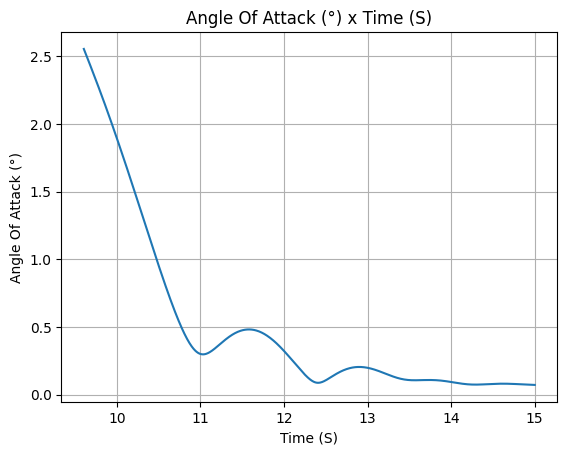

In [22]:
test_flight.angle_of_attack.plot(test_flight.out_of_rail_time, 15)


Initial Conditions

Initial time: 0.000 s
Position - x: 0.00 m | y: 0.00 m | z: 0.00 m
Velocity - Vx: 0.00 m/s | Vy: 0.00 m/s | Vz: 0.00 m/s
Attitude (quaternions) - e0: 0.980 | e1: 0.000 | e2: 0.000 | e3: -0.199
Euler Angles - Spin φ : -191.50° | Nutation θ: 0.00° | Precession ψ: 168.50°
Angular Velocity - ω1: 0.00 rad/s | ω2: 0.00 rad/s | ω3: 0.00 rad/s
Initial Stability Margin: 2.699 c


Surface Wind Conditions

Frontal Surface Wind Speed: 0.39 m/s
Lateral Surface Wind Speed: -0.92 m/s


Launch Rail

Launch Rail Length: 18.28 m
Launch Rail Inclination: 90.00°
Launch Rail Heading: 23.00°


Rail Departure State

Rail Departure Time: 9.604 s
Rail Departure Velocity: 21.742 m/s
Rail Departure Stability Margin: 2.697 c
Rail Departure Angle of Attack: 2.554°
Rail Departure Thrust-Weight Ratio: 2.223
Rail Departure Reynolds Number: 2.916e+05


Burn out State

Burn out time: 20.000 s
Altitude at burn out: 1095.424 m (ASL) | 1095.424 m (AGL)
Rocket speed at burn out: 199.288 m/s
Freestream 

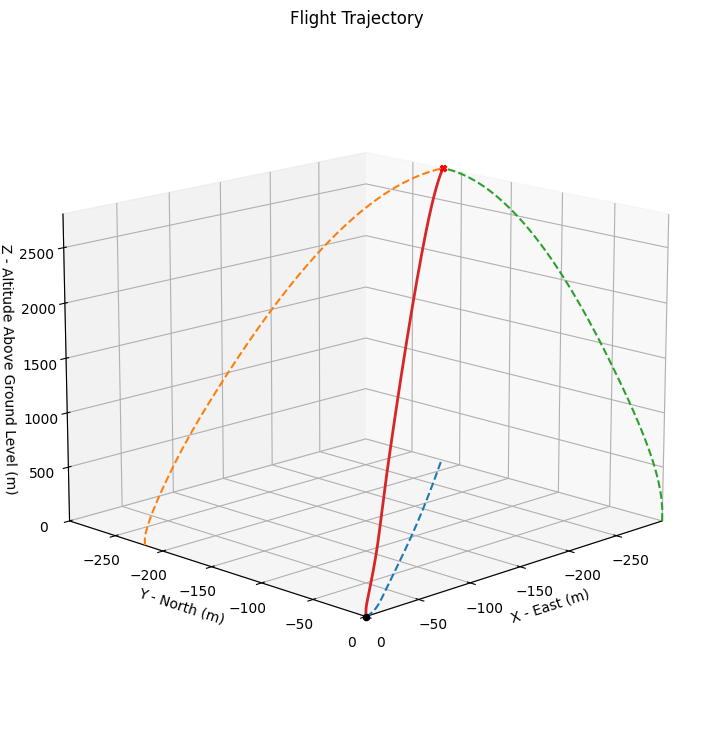



Trajectory Kinematic Plots



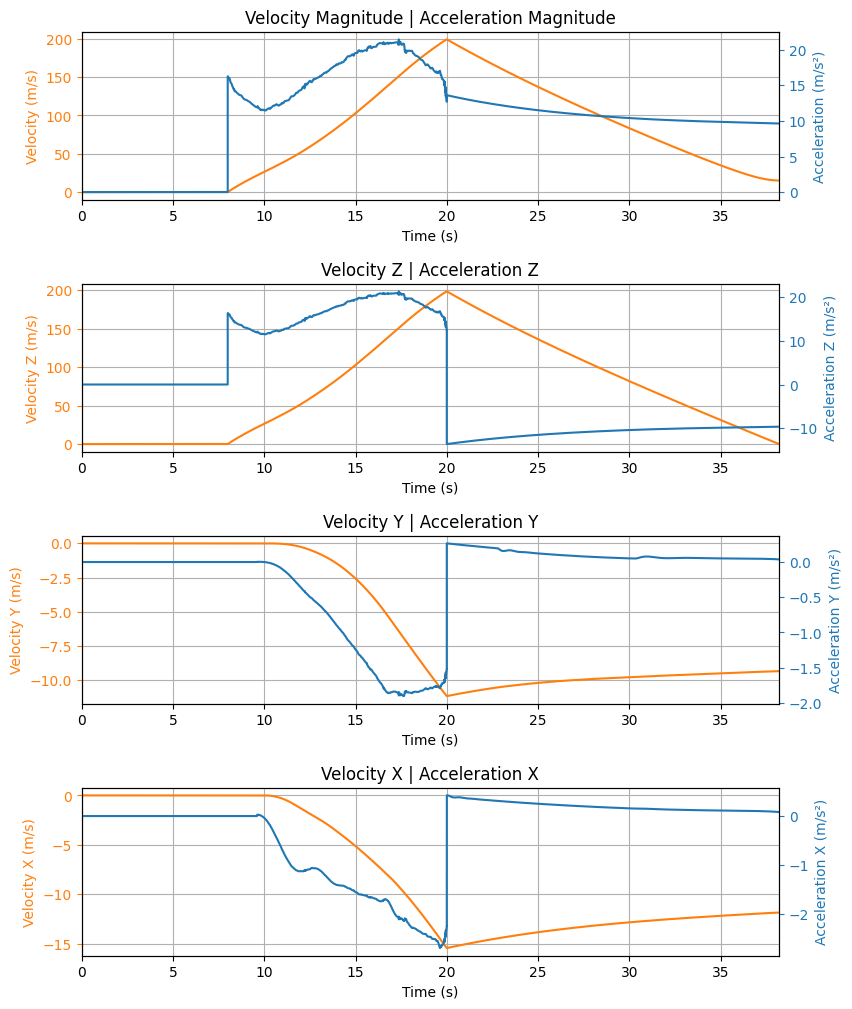



Angular Position Plots



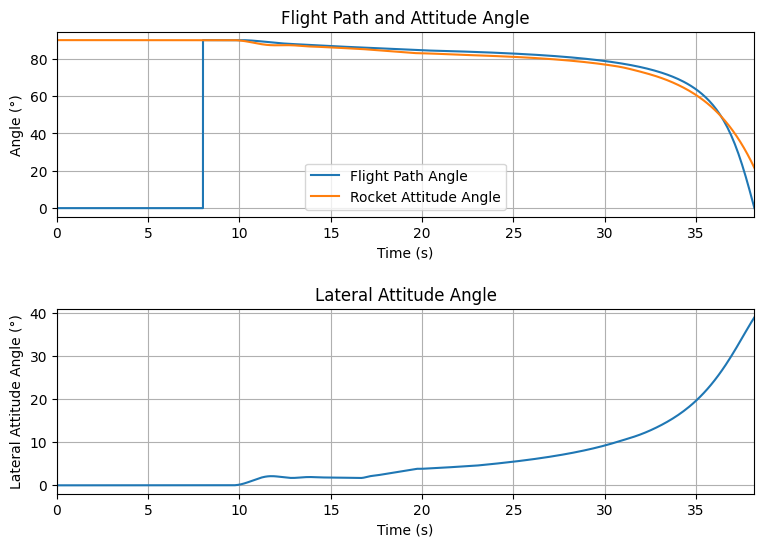



Path, Attitude and Lateral Attitude Angle plots



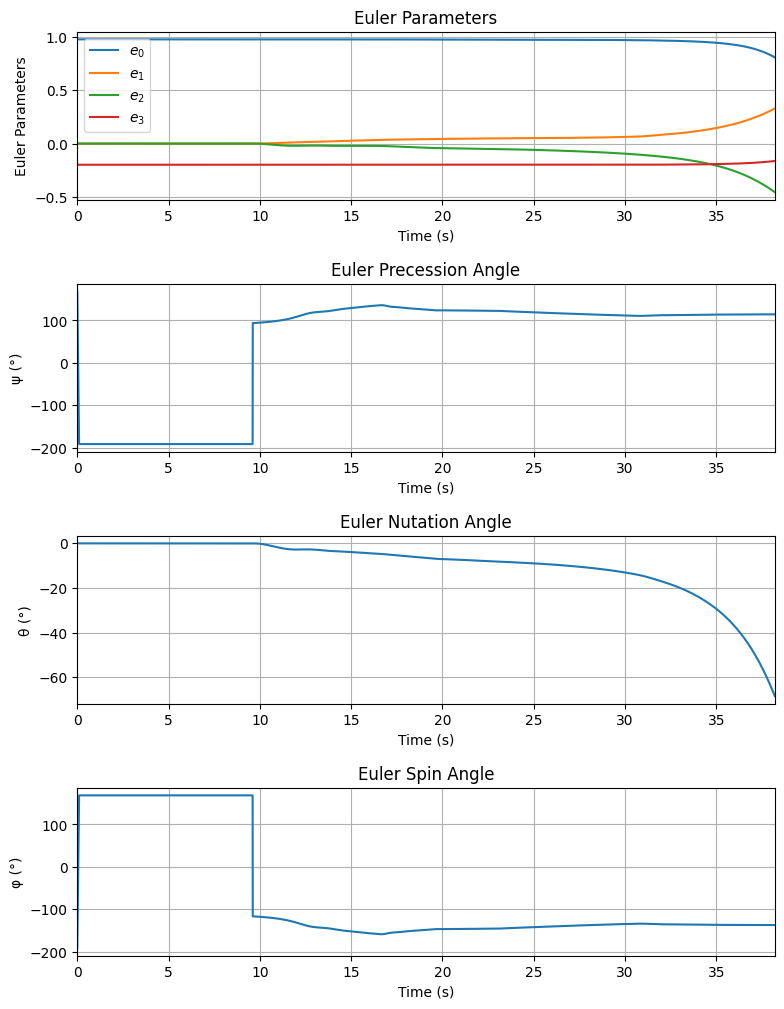



Trajectory Angular Velocity and Acceleration Plots



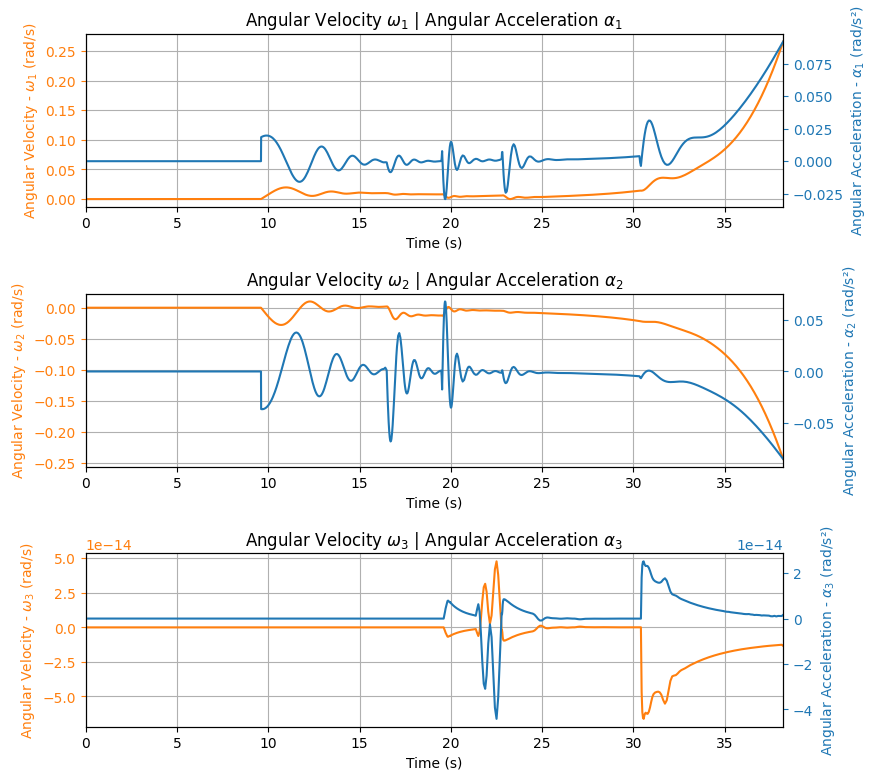



Aerodynamic Forces Plots



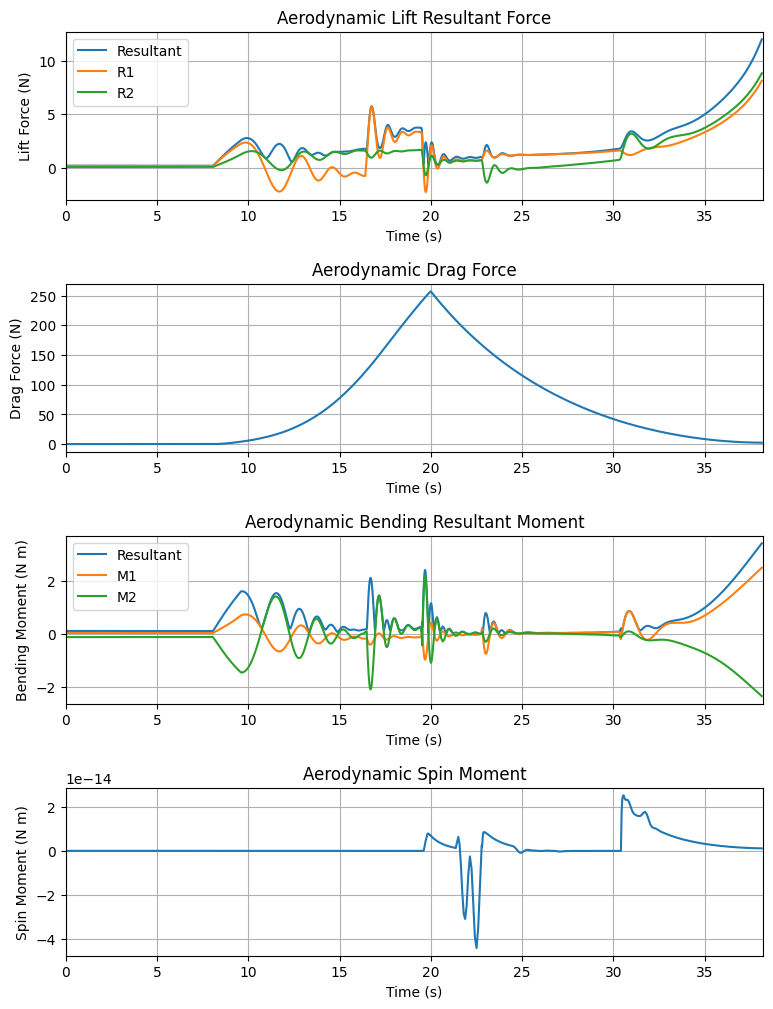



Rail Buttons Forces Plots

No rail buttons were defined. Skipping rail button plots.


Trajectory Energy Plots



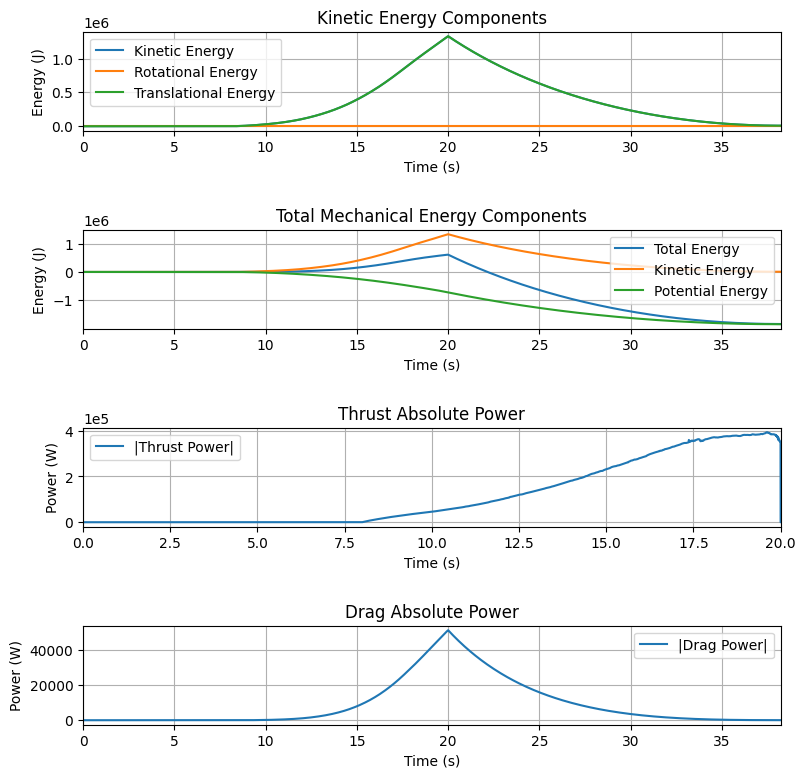



Trajectory Fluid Mechanics Plots



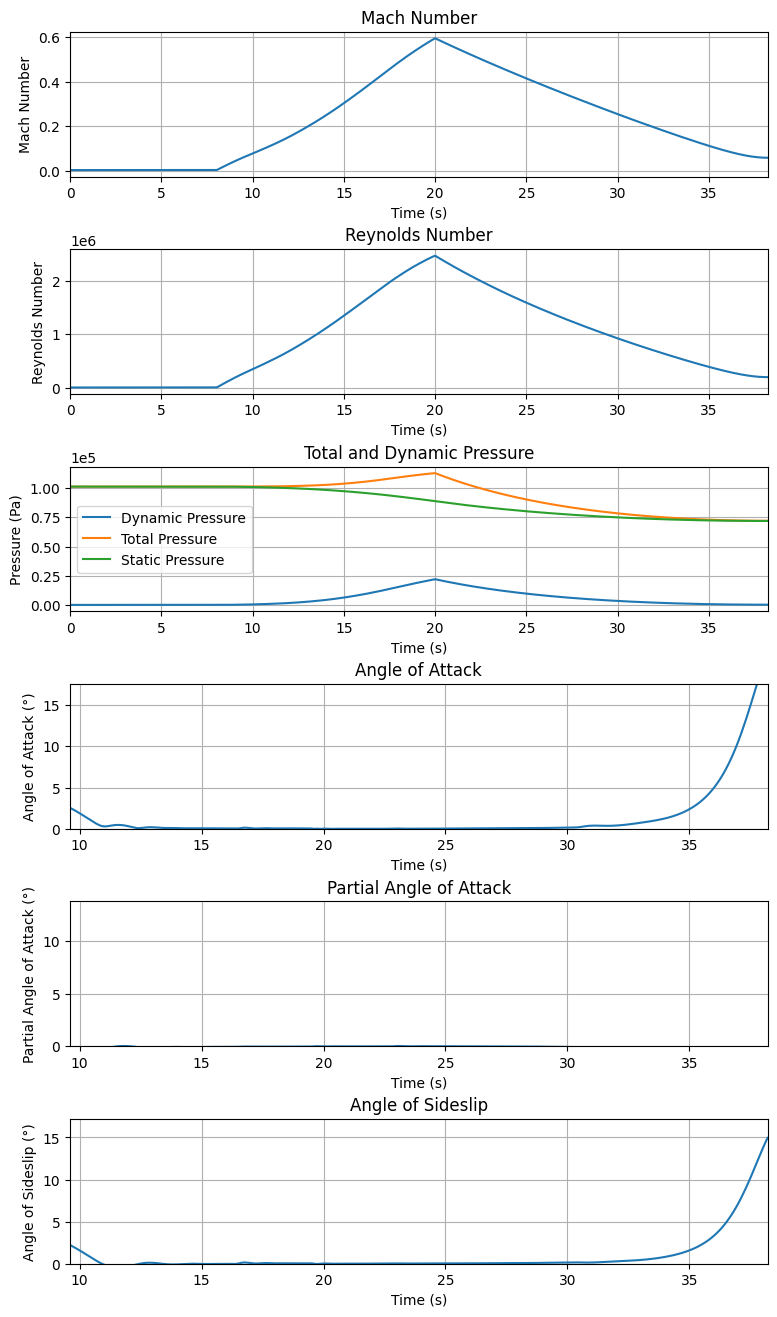



Trajectory Stability and Control Plots



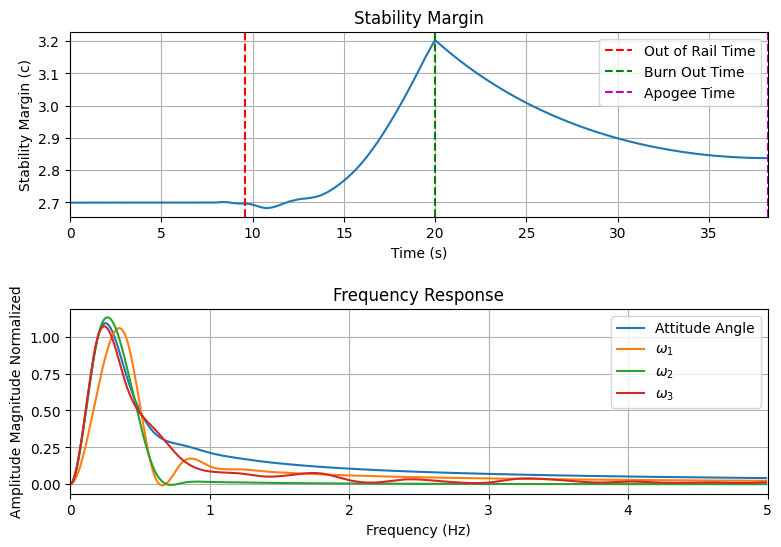



Rocket and Parachute Pressure Plots



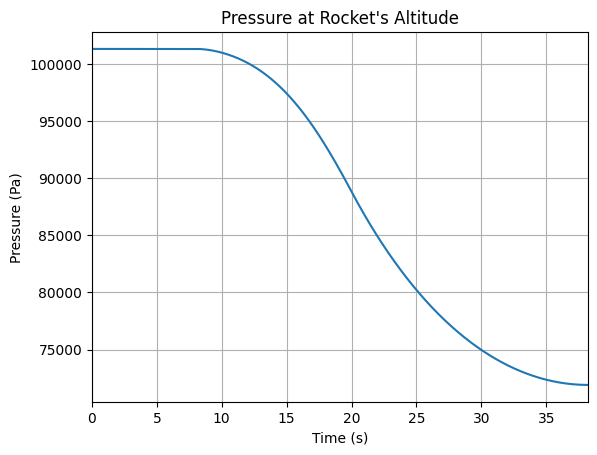


Rocket has no parachutes. No parachute plots available


In [23]:
test_flight.all_info()